In [17]:
library(ggplot2)
library(readxl)
library(dplyr)
library(lmerTest)
library(tidyr)

#import warnings
#warnings.filterwarnings("ignore")

ERROR: Error in parse(text = x, srcfile = src): <text>:7:8: unexpected symbol
6: 
7: import warnings
          ^


## read data from six models:

In [2]:
df_rob_b = data.frame(read_excel("Result_roberta_base.xlsx"))
df_ber_b = data.frame(read_excel("Result_bert_base.xlsx"))
df_ele_l = data.frame(read_excel("Result_electra-large.xlsx"))
df_ern = data.frame(read_excel("Result_ernie.xlsx"))
df_mac_b = data.frame(read_excel("Result_macbert_base.xlsx"))
df_mac_l = data.frame(read_excel("Result_macbert_large.xlsx"))

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1



In [3]:
df_rob_b2 <- df_rob_b %>% mutate(model = "RoBERTa-base")
df_ber_b2 <- df_ber_b %>% mutate(model = "BERT-base")
df_ele_l2 <- df_ele_l %>% mutate(model = "ELECTRA-large")
df_ern2 <- df_ern %>% mutate(model = "ERNIE 1.0")
df_mac_b2 <- df_mac_b %>% mutate(model = "MacBERT-base")
df_mac_l2 <- df_mac_l %>% mutate(model = "MacBERT-large")

In [4]:
df_model <- rbind(rbind(rbind(rbind(rbind(df_rob_b2,df_ber_b2),df_ele_l2),df_ern2),df_mac_b2),df_mac_l2)
df_model <- df_model %>% dplyr::select(-MaskedSentence) 

df_model$telic = substr(df_model$Verb,1,1)
df_model <- df_model %>% mutate(surp_ba = -log(df_model$prob_ba+exp(-30), base = 2))%>%
mutate(surp_bei = -log(df_model$prob_bei+exp(-30), base = 2)) %>% mutate(diff_babei = surp_ba - surp_bei) %>% 
mutate(telic = case_when(telic == 's' ~ 'spatial',TRUE ~ 'temporal'))

head(df_model)
print(unique(df_model$model))
print(unique(df_model$Condition))
nrow(df_model)

,...1,Verb,Condition,prob_ba,prob_bei,model,telic,surp_ba,surp_bei,diff_babei
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,0,t-da,volition,0.5393090,0.04622619,RoBERTa-base,temporal,0.8908159,4.435146,-3.544330
2,1,t-zou,volition,0.5177114,0.02453453,RoBERTa-base,temporal,0.9497800,5.349043,-4.399263
3,2,t-ma,volition,0.5981696,0.09119784,RoBERTa-base,temporal,0.7413734,3.454857,-2.713483
4,3,t-kua,volition,0.5203686,0.08072345,RoBERTa-base,temporal,0.9423943,3.630868,-2.688474
5,4,t-piping,volition,0.4376158,0.11551106,RoBERTa-base,temporal,1.1922634,3.113897,-1.921634
6,5,t-zanmei,volition,0.3788700,0.12027913,RoBERTa-base,temporal,1.4002251,3.055542,-1.655317


[1] "RoBERTa-base"  "BERT-base"     "ELECTRA-large" "ERNIE 1.0"    
[5] "MacBERT-base"  "MacBERT-large"
[1] "volition"     "non-volition" "do"           "happen"       "NP2_com"     
[6] "telic"        "atelic"       "NP1_com"      "aim"         


[1] 972

## read data from human accepatability judgment task:

In [5]:
df_read_hum = data.frame(read_excel("Result_human.xlsx"))
df_read_hum <- df_read_hum %>% dplyr::select(-List, -Items) 
df_read_hum$telic = substr(df_read_hum$Verb,1,1)
print(length(unique(df_read_hum$Participant)))

df_hum_filler <- df_read_hum %>% filter(Verb == "x-filler")
sum_hum_filler <- df_hum_filler %>% group_by(Participant)%>% summarise(Mean = mean(Value))
#ggplot(sum_hum_filler, aes(x = Mean)) + geom_histogram(binwidth = 0.1)
df_remove <- sum_hum_filler %>% filter(Mean < 3.5) 
removelist <- unique(df_remove$Participant)
print(removelist)

df_hum <- df_read_hum %>% filter(Verb != "x-filler") %>% filter(!Participant %in% removelist) %>% 
mutate(telic = case_when(telic == 's' ~ 'spatial',TRUE ~ 'temporal'))

head(df_hum)
print(length(unique(df_hum$Participant)))

[1] 121
 [1]   6  13  33  34  35  59  69  74  75  81  94 119


,Participant,BABEI,Condition,Verb,Value,telic
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,bei,atelic,s-la,2,spatial
2,1,ba,aim,t-xunchi,1,temporal
3,1,ba,volition,t-da,1,temporal
4,1,ba,telic,t-zanmei,1,temporal
5,1,bei,aim,s-guan,4,spatial
6,1,ba,atelic,t-jiaoxun,3,temporal


[1] 109


## calculate B_hum and B_LMs:

`summarise()` has grouped output by 'Verb'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'Verb'. You can override using the `.groups` argument.



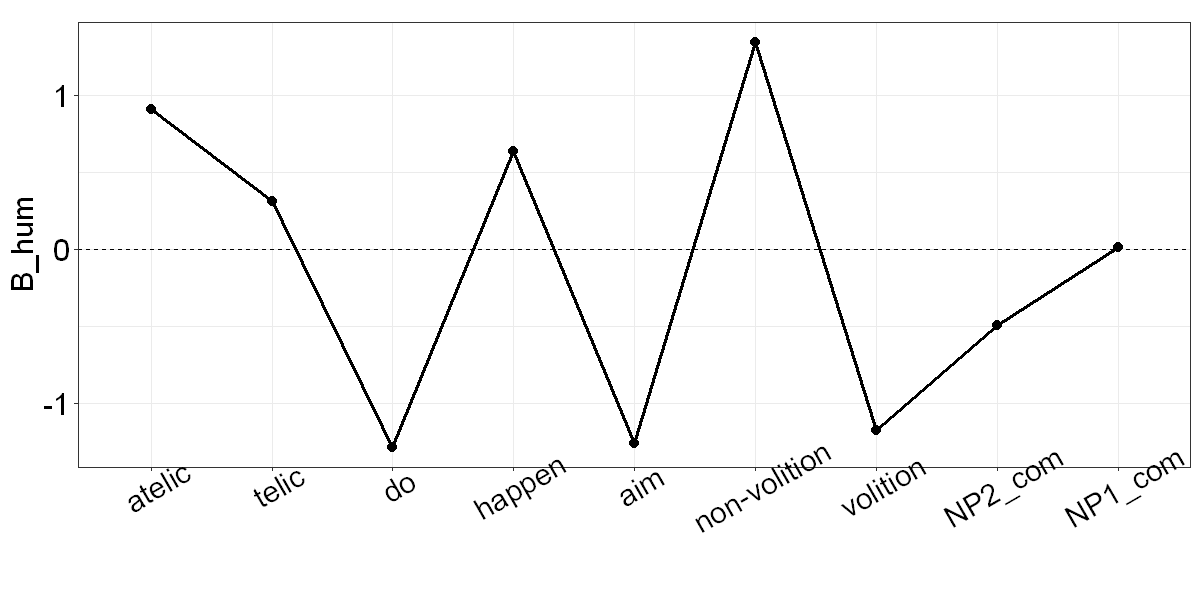

In [6]:
# for human accepatability judgment:

sum_hum_ba <- df_hum %>% filter(BABEI == "ba") %>% group_by(Verb, Condition)%>% 
summarise(ba_mean = mean(Value))

sum_hum_bei <- df_hum %>% filter(BABEI == "bei") %>% group_by(Verb, Condition)%>% 
summarise(bei_mean = mean(Value))

sum_hum_babei <- sum_hum_ba %>% right_join(sum_hum_bei, by=c("Verb","Condition")) %>% mutate(diff_babei = ba_mean - bei_mean) 
sum_hum <- sum_hum_babei %>% group_by(Condition)%>% summarise(Mean = mean(diff_babei))


# plot B_hum for human accepatability judgment:

options(repr.plot.width=10, repr.plot.height=5)
level = c("atelic","telic","do" ,"happen" , "aim",  "non-volition", "volition" , "NP2_com" ,"NP1_com")

plot_hum <- ggplot(sum_hum, aes(x = factor(Condition,levels = level), y = Mean))  +
    geom_point(size = 2.5)+ geom_line(aes(group = as.numeric(Condition), size= 1), size = 1) + 
theme_bw() + 
theme(axis.text.x = element_text(size=18,color = "black", angle = 30), 
      axis.title.x = element_blank(),
      axis.text.y = element_text(size=18,color = "black"),  
      axis.title.y = element_text(size = 18, color = "black"),
      legend.text = element_text(size= 18), 
      legend.title=element_blank(),
      aspect.ratio = 4/10) + 
labs(y = "B_hum") +
scale_y_continuous(breaks = seq(-1.0, 1.0, by = 1))+
geom_hline(aes(yintercept = 0), linetype="dashed")

plot_hum

`summarise()` has grouped output by 'Condition'. You can override using the `.groups` argument.



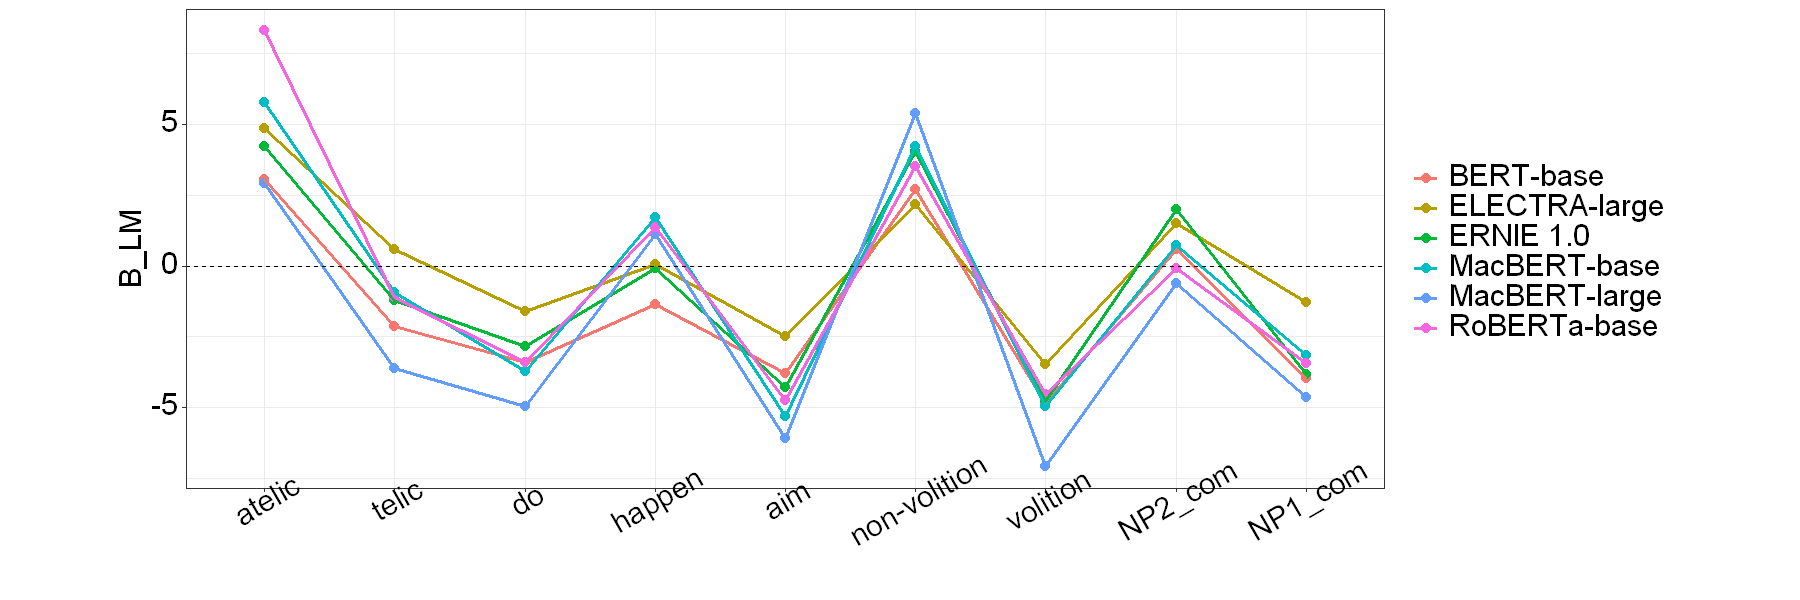

In [7]:
# lot B_LM for models:

sum_mod <- df_model %>% select(Condition, model, diff_babei) %>% group_by( Condition, model) %>% 
summarise(Mean = mean(diff_babei))

options(repr.plot.width=15, repr.plot.height=5)
level = c("atelic","telic","do" ,"happen" , "aim",  "non-volition", "volition" , "NP2_com" ,"NP1_com")


plot_mod <- ggplot(sum_mod, aes(x = factor(Condition,levels = level), y = Mean, color = model, group = model))  +
    geom_point(size = 2.5)+ geom_line(size = 1) + 
theme_bw() + 
theme(axis.text.x = element_text(size=18,color = "black", angle = 30), 
      axis.title.x = element_blank(),
      axis.text.y = element_text(size=18,color = "black"),  
      axis.title.y = element_text(size = 18, color = "black"),
      legend.text = element_text(size= 18), 
      legend.title=element_blank(),
      aspect.ratio = 4/10) + 
labs(y = "B_LM") +
geom_hline(aes(yintercept = 0), linetype="dashed")

plot_mod

In [84]:
sum_mod <- df_model %>% select(Condition, model, diff_babei) %>% group_by( Condition, model) %>% 
summarise(Mean = mean(diff_babei), SD = sd(diff_babei))

`summarise()` has grouped output by 'Condition'. You can override using the `.groups` argument.



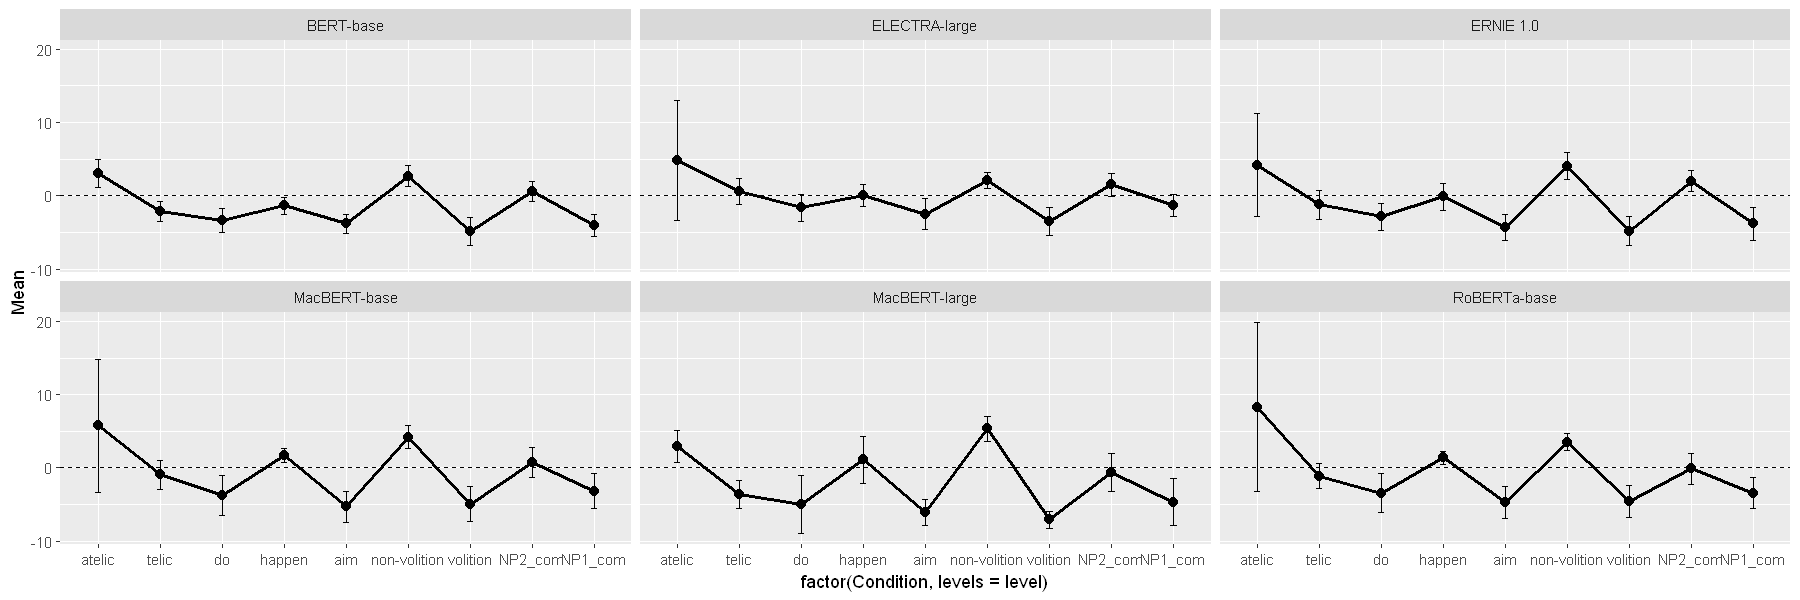

In [90]:
options(repr.plot.width=15, repr.plot.height=5)
level = c("atelic","telic","do" ,"happen" , "aim",  "non-volition", "volition" , "NP2_com" ,"NP1_com")


ggplot(sum_mod, aes(x = factor(Condition,levels = level), y = Mean))  +
    geom_point(size = 2.5)+ geom_line(aes(group = as.numeric(Condition), size= 1), size = 1) + facet_wrap(~model) +
geom_errorbar(aes(ymin=Mean-SD, ymax=Mean+SD), width=.1) +
geom_hline(aes(yintercept = 0), linetype="dashed")


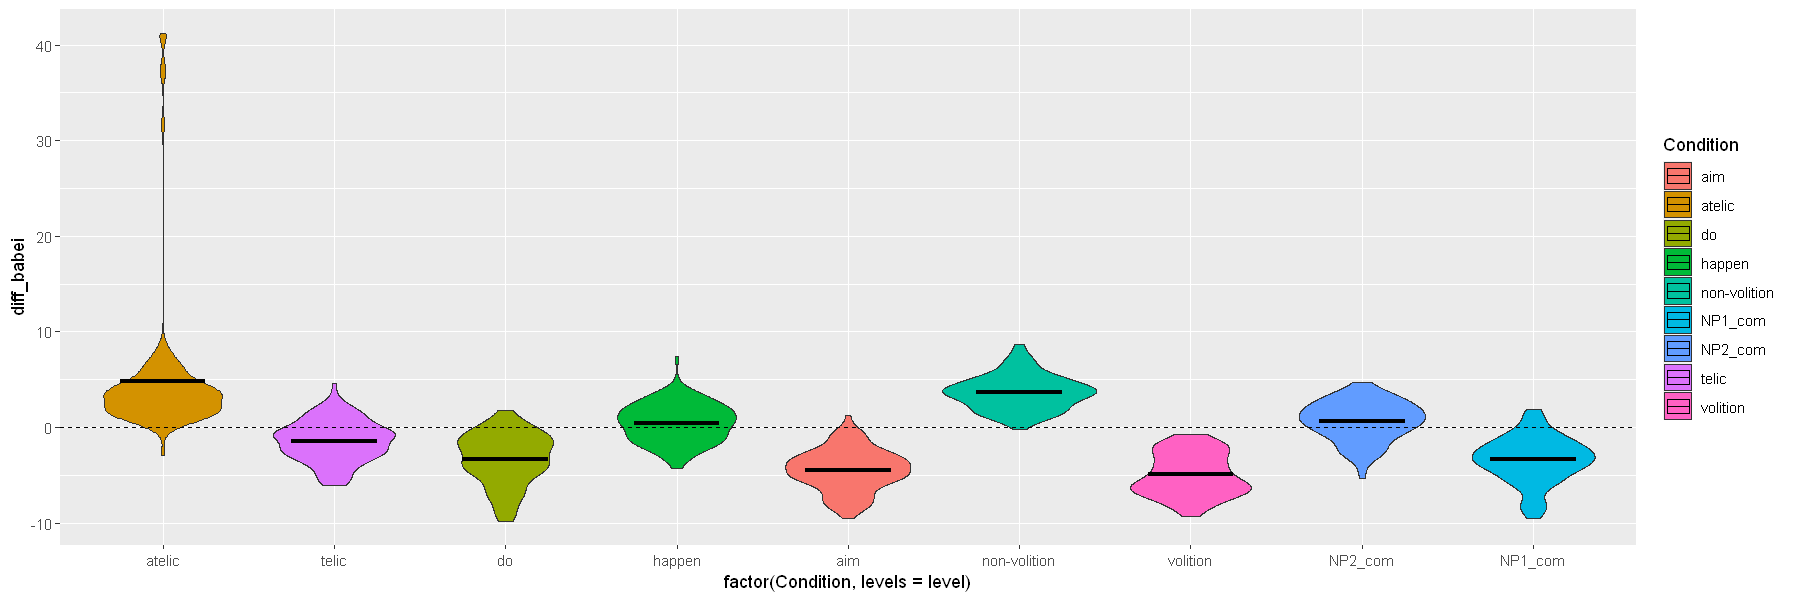

In [94]:
ggplot(df_model, aes(x = factor(Condition,levels = level), y=diff_babei, fill=Condition)) +
  geom_violin()+
geom_hline(aes(yintercept = 0), linetype="dashed") +
stat_summary(fun = "mean",geom = "crossbar", width = 0.5,colour = "black")

In [10]:
head(df_model)
unique(df_model$Verb)

,...1,Verb,Condition,prob_ba,prob_bei,model,telic,surp_ba,surp_bei,diff_babei
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,0,t-da,volition,0.5393090,0.04622619,RoBERTa-base,temporal,0.8908159,4.435146,-3.544330
2,1,t-zou,volition,0.5177114,0.02453453,RoBERTa-base,temporal,0.9497800,5.349043,-4.399263
3,2,t-ma,volition,0.5981696,0.09119784,RoBERTa-base,temporal,0.7413734,3.454857,-2.713483
4,3,t-kua,volition,0.5203686,0.08072345,RoBERTa-base,temporal,0.9423943,3.630868,-2.688474
5,4,t-piping,volition,0.4376158,0.11551106,RoBERTa-base,temporal,1.1922634,3.113897,-1.921634
6,5,t-zanmei,volition,0.3788700,0.12027913,RoBERTa-base,temporal,1.4002251,3.055542,-1.655317


[1] "t-da"      "t-zou"     "t-ma"      "t-kua"     "t-piping"  "t-zanmei" 
 [7] "t-jiaoxun" "t-shuluo"  "t-xunchi"  "s-bao"     "s-bang"    "s-mai"    
[13] "s-tai"     "s-tuo"     "s-zhuai"   "s-la"      "s-tui"     "s-guan"

In [69]:
df_model_vio <- df_model %>% mutate(choice = if_else(surp_ba > surp_bei, 0, 1))

,...1,Verb,Condition,prob_ba,prob_bei,model,telic,surp_ba,surp_bei,diff_babei,choice
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,t-da,volition,0.5393090,0.04622619,RoBERTa-base,temporal,0.8908159,4.435146,-3.544330,1
2,1,t-zou,volition,0.5177114,0.02453453,RoBERTa-base,temporal,0.9497800,5.349043,-4.399263,1
3,2,t-ma,volition,0.5981696,0.09119784,RoBERTa-base,temporal,0.7413734,3.454857,-2.713483,1


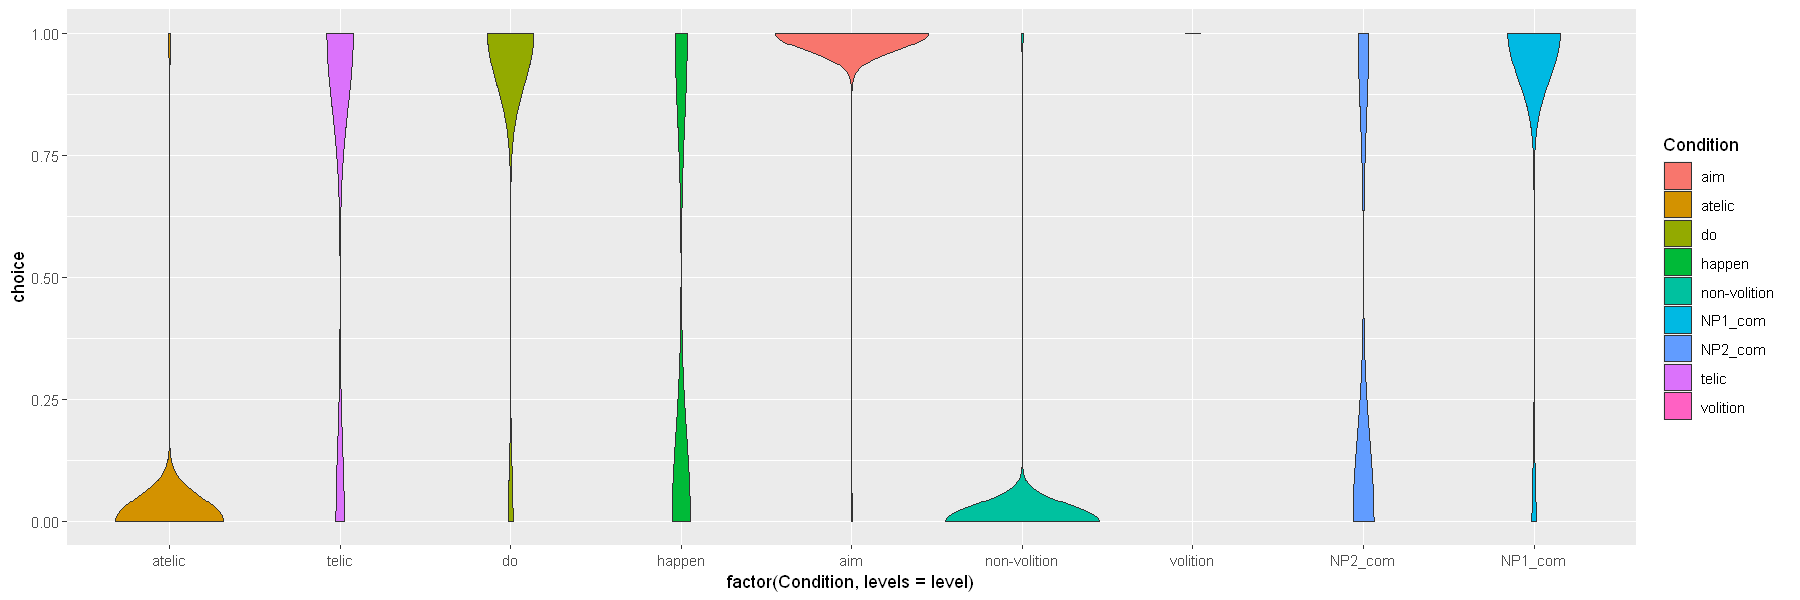

In [70]:
head(df_model_vio,3)
ggplot(df_model_vio, aes(x = factor(Condition,levels = level), y=choice, fill=Condition)) +
  geom_violin()

In [71]:
d <- df_model_vio %>% filter(Condition == "atelic")
table(d$choice)


  0   1 
106   2 

In [72]:
d <- df_model_vio %>% filter(Condition == "telic")
table(d$choice)


 0  1 
26 82 

In [73]:
d <- df_model_vio %>% filter(Condition == "volition")
table(d$choice)


  1 
108 

In [77]:
n <- df_model_vio %>% filter(Verb == "t-da" & Condition == "telic")
mean(n$choice)

[1] 0.8333333

`summarise()` has grouped output by 'Verb'. You can override using the `.groups` argument.



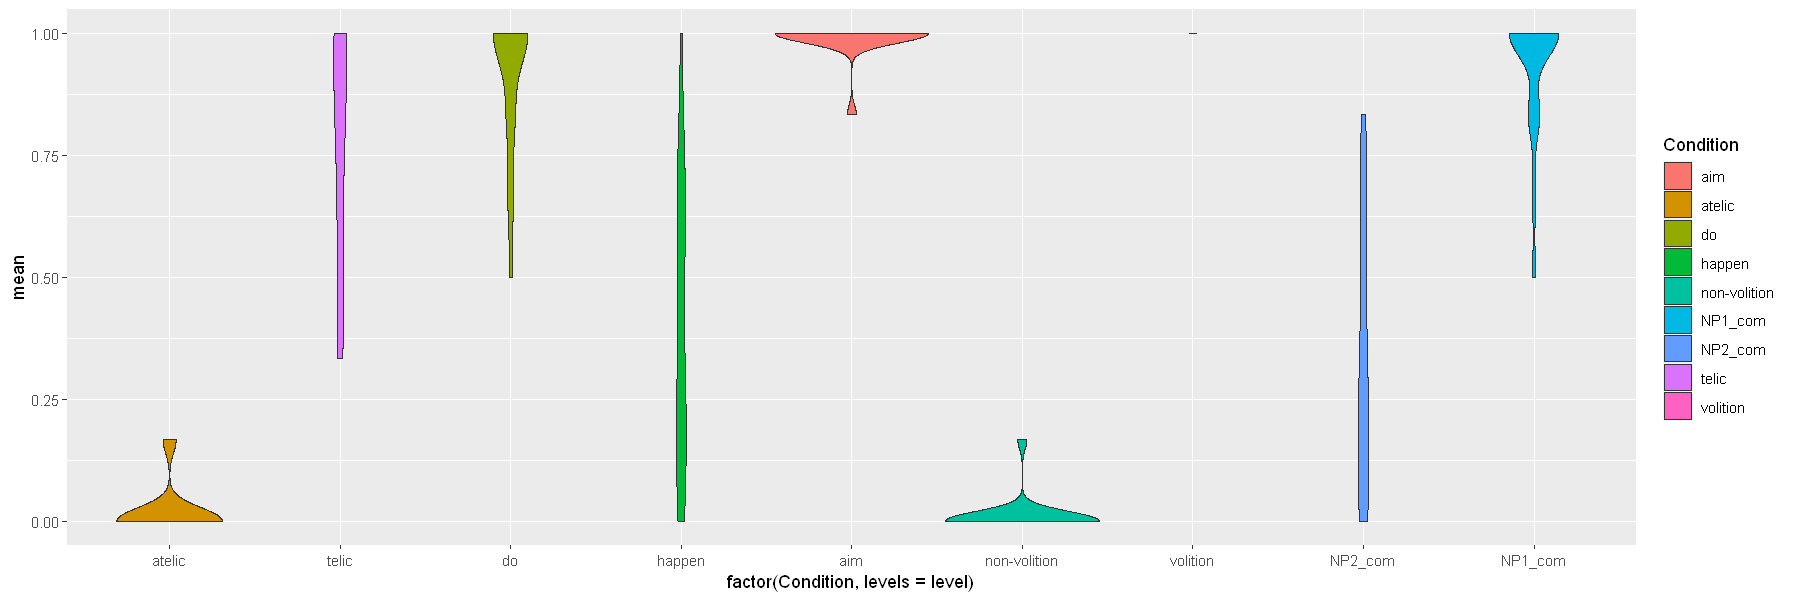

In [80]:
n <- df_model_vio %>%  group_by(Verb, Condition)%>% summarise(mean = mean(choice))
ggplot(n, aes(x = factor(Condition,levels = level), y=mean, fill=Condition)) +
  geom_violin()

## calculate surprisal/accepatability value for BA and BEI:

`summarise()` has grouped output by 'Condition'. You can override using the `.groups` argument.



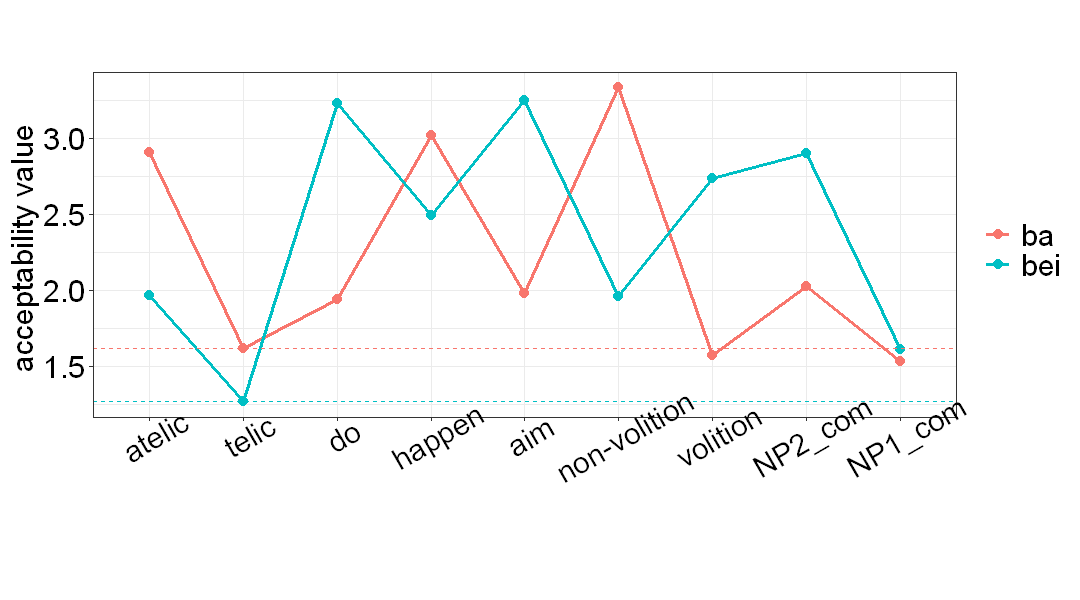

In [45]:
# plot acceptability value for humans:

sum_hum_acc <- df_hum %>% group_by(Condition, BABEI) %>% summarise(Mean = mean(Value))
line_hum <- sum_hum_acc %>% filter(Condition == "telic")

options(repr.plot.width=9, repr.plot.height=5)

plot_hum_acc <- ggplot(sum_hum_acc, aes(x = factor(Condition,levels = level), y = Mean, color = BABEI, group = BABEI))  +
    geom_point(size = 2.5)+ geom_line(size= 1) + theme_bw() + 
theme(axis.text.x = element_text(size=18,color = "black", angle = 30), 
      axis.title.x = element_blank(),
      axis.text.y = element_text(size=18,color = "black"),  
      axis.title.y = element_text(size = 18, color = "black"),
      legend.text = element_text(size= 18), 
      legend.title=element_blank(),
      aspect.ratio = 4/10) + 
labs(y = "acceptability value ") +
geom_hline(data = line_hum, aes(yintercept = Mean, group = BABEI, color = BABEI), linetype="dashed")

plot_hum_acc

`summarise()` has grouped output by 'Condition'. You can override using the `.groups` argument.



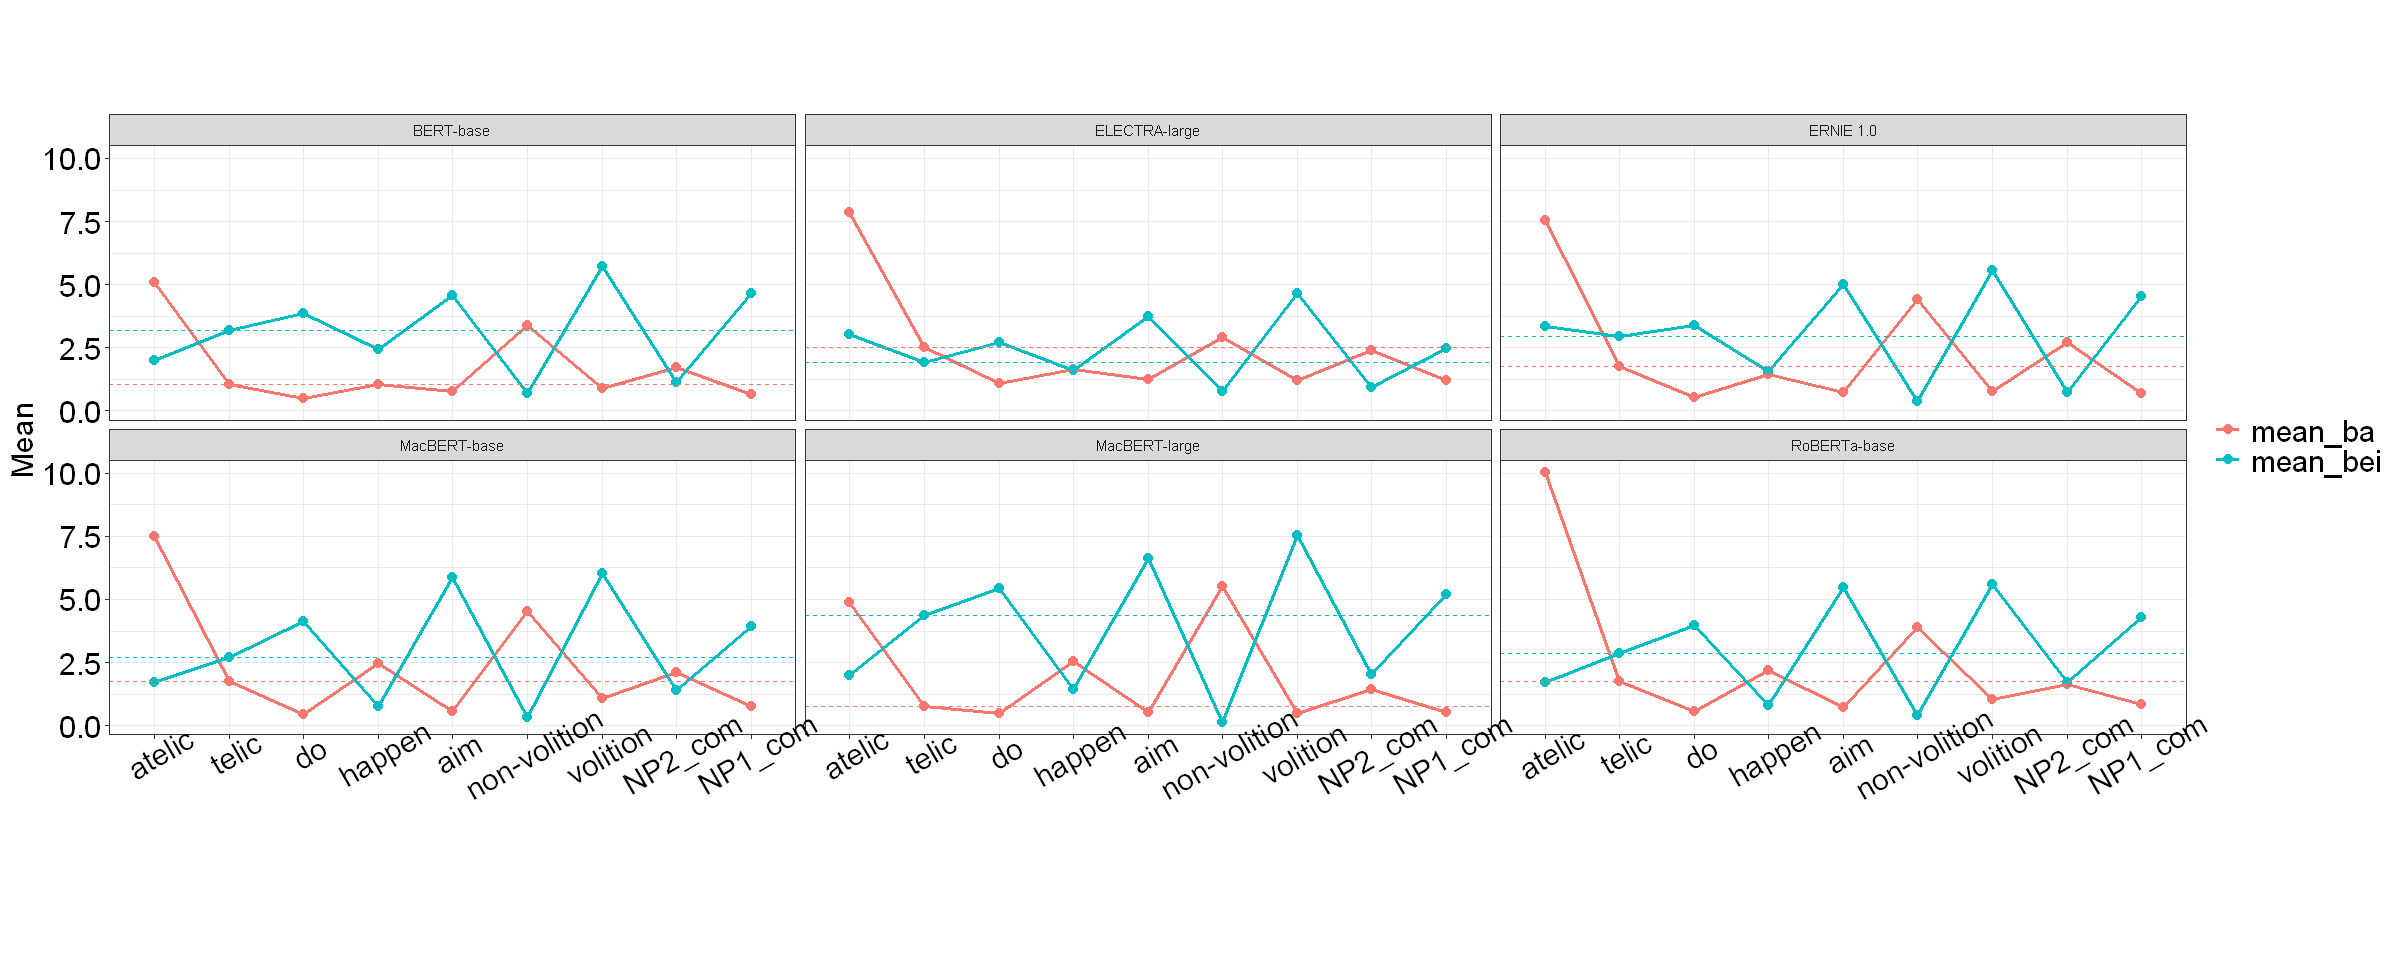

In [46]:
# plot surprisal value for models:

sum_mod_surp <- df_model  %>% group_by(Condition, model) %>%  summarize(mean_ba = mean(surp_ba), mean_bei = mean(surp_bei))%>% 
gather(BABEI, Mean, mean_ba:mean_bei)
line_mod <- sum_mod_surp %>% filter(Condition == "telic")

options(repr.plot.width=20, repr.plot.height=8)

plot_mod_surp <- ggplot(sum_mod_surp, aes(x = factor(Condition,levels = level), y = Mean, color = BABEI, group = BABEI))  +
    geom_point(size = 2.5)+ geom_line(size= 1) + facet_wrap(~ model) + theme_bw() + 
theme(axis.text.x = element_text(size=18,color = "black", angle = 30), 
      axis.title.x = element_blank(),
      axis.text.y = element_text(size=18,color = "black"),  
      axis.title.y = element_text(size = 18, color = "black"),
      legend.text = element_text(size= 18), 
      legend.title=element_blank(),
      aspect.ratio = 4/10) +
geom_hline(data = line_mod, aes(yintercept = Mean, group = BABEI, color = BABEI), linetype="dashed")

plot_mod_surp

## fit linear mixed-effects models for telic items with temporal vs. spatial endpoint:

In [47]:
# ba vs. bei in telic condition in human judgment:

m_hum_tem <- lmer(Value ~ BABEI   + (1|Verb) , data = df_hum %>% filter(Condition == "telic" &  telic == "temporal"))
data.frame(coef(summary(m_hum_tem)))

m_hum_spa <- lmer(Value ~ BABEI   + (1|Verb) , data = df_hum %>% filter(Condition == "telic" &  telic == "spatial"))
data.frame(coef(summary(m_hum_spa)))

,Estimate,Std..Error,df,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.8506397,0.09989075,19.60073,18.526638,6.915383e-14
BABEIbei,-0.6611614,0.15772650,102.42853,-4.191822,5.885515e-05


,Estimate,Std..Error,df,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.3299515,0.09425717,21.8156,14.10981885,1.910345e-12
BABEIbei,0.0112173,0.11934835,106.0278,0.09398788,9.252962e-01


In [48]:
head(df_mod_m,3)
unique(df_mod_m$telic)

,...1,Verb,Condition,prob_ba,prob_bei,model,telic,diff_babei,BABEI,Value
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,90,temp-da,telic,0.3949664,0.1831478,RoBERTa-base,temp,-1.10872127,surp_ba,1.340198
2,91,temp-zou,telic,0.3729594,0.1844412,RoBERTa-base,temp,-1.01585746,surp_ba,1.422909
3,92,temp-ma,telic,0.3819630,0.3572374,RoBERTa-base,temp,-0.09654972,surp_ba,1.388495


[1] "temp" "spac"

In [49]:
# ba vs. bei in telic condition for model "RoBERTa-base":

df_mod_m <- df_model %>% filter(Condition == "telic" & model == "RoBERTa-base") %>% gather(BABEI, Value, surp_ba:surp_bei)

m_mod_tem <- lmer(Value ~ BABEI    + (1|Verb) , data= df_mod_m %>% filter(telic == "temporal"))
data.frame(coef(summary(m_mod_tem)))

m_mod_spa <- lmer(Value ~ BABEI   + (1|Verb) , data= df_mod_m %>% filter(telic == "spatial")) 
data.frame(coef(summary(m_mod_spa)))

boundary (singular) fit: see ?isSingular



,Estimate,Std..Error,df,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.8546223,0.192763,16,9.621259,4.687687e-08
BABEIsurp_bei,-0.1579106,0.272608,16,-0.579259,5.704807e-01


boundary (singular) fit: see ?isSingular



,Estimate,Std..Error,df,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.658346,0.2640663,16,6.280037,1.096849e-05
BABEIsurp_bei,2.397317,0.3734461,16,6.419445,8.484087e-06
